In [26]:
import pystan
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

%matplotlib inline

In [18]:
### Import get columns and rows
data = pd.read_csv("co2.csv",sep=',', comment='"',header=None)


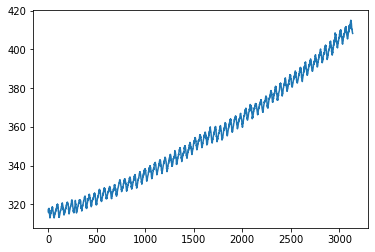

In [25]:
plt.plot([x for x in range(3139)],data.loc[:][1]);
plt.show();

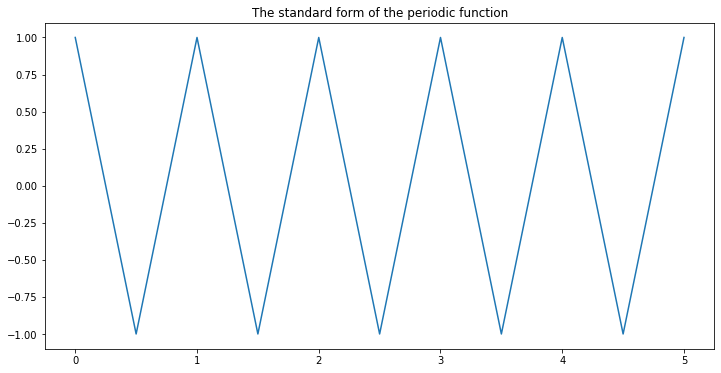

In [27]:
def f(x, A=1, lambd=1, phi=0, sigma=0):
    '''
    A periodic triangle function with specified amplitude, frequency, phase,
    and optional noise added to the function value.

    Inputs:

        x (float or array): The input value(s) at which to evaluate the
          function.

        A (float): The amplitude of the function. The non-noisy function
          value will vary from -A to A. Default: 1.

        lambda (float): The frequency of the function. There will will be
          lambda waves per unit of `x`. Default: 1.

        phi (float): The phase offset of the function. The graph of the
          function moves to the left by this many waves. Note that `phi`
          is periodic in the range [0, 1], so setting `phi = 1.2` will
          have the same effect as setting `phi = 0.2` or `phi = `2.2`.
          Default: 0.

        sigma (float): The amount of noise to add to the function value,
          interpreted as the standard deviation of zero-mean Gaussian
          noise. Default: 0.

    Returns: (float or array) matching the dimensions of `x` with the
      periodic function values.
    '''
    return (
        A * (4 * abs((lambd * x + phi) % 1 - 0.5) - 1) +
        stats.norm.rvs(0, sigma, size=np.shape(x)))

plot_x = np.linspace(0, 5, 501)
plt.figure(figsize=(12, 6))
plt.plot(plot_x, f(plot_x))
plt.title('The standard form of the periodic function')
plt.show()

In [28]:
# setup model data

n = 1500
n_future = 3139 - n


In [31]:
stan_data = {
    'n': n,
    'n_future': n_future,
    'x': data.loc[:n-1][1]}  # Stan gets to see the first n data values only


In [29]:
# The Stan model. Running this cell compiles the Stan model, which takes
# some time.

stan_code = """
data {
    int<lower=0> n;        // The number of data
    real x[n];             // The data
    int<lower=0> n_future; // The number of future values to predict
}

parameters {
    real<lower=0> A;
    real<lower=0> lambda;
    real<lower=0> sigma;

    // We need a periodic phi
    real phi_x;
    real phi_y;
}

transformed parameters {
    real<lower=0,upper=1> phi;

    // The atan2 function returns a value in the range [-pi, pi], which we
    // then transform linearly into the range [0, 1].
    phi = atan2(phi_x, phi_y) / (2 * pi()) + 0.5;
}

model {
    A ~ normal(0, 5);
    phi_x ~ normal(0, 1);
    phi_y ~ normal(0, 1);
    sigma ~ gamma(1, 0.3);
    for(t in 1:n) {
        x[t] ~ normal(
            A * (4 * fabs(fmod(lambda * t + phi, 1) - 0.5) - 1),
            sigma);
    }
}

// Generate the predicted function values for the next n_future steps.
generated quantities {
    real x_future[n_future];
    for(t in 1:n_future) {
        x_future[t] = normal_rng(
            A * (4 * fabs(fmod(lambda * (t + n) + phi, 1) - 0.5) - 1),
            sigma);
    }
}
"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_299aa46eac284b1ecd4d5dda095fa602 NOW.


In [32]:
# Run Hamiltonian Monte Carlo using Stan with 4 Markov chains, a 1000 step
# warm-up phase and 1000 step sampling phase for each chain. The warm-up samples
# are discarded, so we are left with 4 x 1000 = 4000 samples.

# This cell will take a minute or two to run.

parameters = ['A', 'lambda', 'phi', 'sigma']

results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars=parameters))
samples = results.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_299aa46eac284b1ecd4d5dda095fa602.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
A       24.09   26.81  37.96   0.89   1.71   2.69  45.96  92.73      2  29.23
lambda   4.58     2.0   2.84    2.0    2.0    3.5   7.72    9.0      2  12.62
phi      0.45    0.25   0.36 6.2e-3   0.15   0.32   0.96   0.99      2   6.38
sigma   317.3    2.49    4.5 312.31 314.87 316.59 317.55 330.48      3   2.11

Samples were drawn using NUTS at Wed Dec 11 14:57:29 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
